In [1]:
import numpy as np

import torch
import torch.utils.data

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

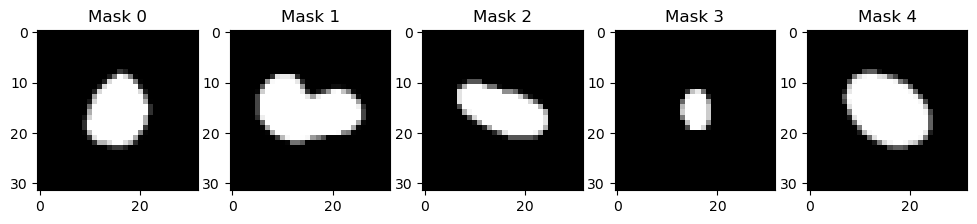

In [2]:
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)

BATCH_SIZE = 100

IMG_FOLDER = "images/bbbc039/masks/"

train_imgs, val_imgs = datasets.split_folder(IMG_FOLDER, 0.9, max_images=1000)

train_auto_dataset = datasets.CachedImages(IMG_FOLDER, train_imgs, train=True, grayscale=True, size=IMAGE_SIZE)
val_auto_dataset = datasets.CachedImages(IMG_FOLDER, val_imgs, grayscale=True, size=IMAGE_SIZE)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Mask {i}", metaimage.Mask(train_auto_dataset[i][0])) for i in range(5)
        ]
    ],
    figsize=(12, 12),
)
display.show()

In [6]:
LATENT_SIZE = 128
BASE_CHANNELS = 8
DISCRIMINATOR_CHANNELS = 4
BACKGROUND_CHANNELS = 8
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.1
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

def create_nnets():
    discriminator = torch.nn.Sequential(
        nnet.blocks.conv.BasicConvBlock(
            in_channels=1,
            out_channels=DISCRIMINATOR_CHANNELS,
            kernel_size=7,
            stride=2,
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0]//2, IMAGE_SIZE[1]//2),
            out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0]//4, 2, 2),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            total_layers=1,
        ),
        nnet.blocks.conv.ConvToLinear(
            (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0]//4, 2, 2),
            out_dim=1,
            activation=torch.nn.Sigmoid,
        ),
    )

    voxel_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
                activation=ACTIVATION,
                dropout=nnet.modules.AlwaysDropout(GENERATOR_DROPOUT, device=DEVICE),
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=nnet.modules.AlwaysDropout(GENERATOR_DROPOUT, device=DEVICE),
            ),
            total_layers=1,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=1,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.VoxGridAlphaAdjust()
    )

    background_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BACKGROUND_CHANNELS * SPACE_SIZE[0]//2, 4, 4),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BACKGROUND_CHANNELS * SPACE_SIZE[0]//2, 4, 4),
            out_shape=(BACKGROUND_CHANNELS, SPACE_SIZE[0]*2, SPACE_SIZE[1]*2),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            total_layers=1,
        ),
        nnet.blocks.resnet.create_resnet_block_simple(
            kernel_size=5,
            in_channels=BACKGROUND_CHANNELS,
            out_channels=BACKGROUND_CHANNELS,
            activation=ACTIVATION, 
        ),
        nnet.blocks.conv.BasicConvBlock(
            in_channels=BACKGROUND_CHANNELS,
            out_channels=3,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.RandomPatch(IMAGE_SIZE)
    )

    mask_generator = nnet.generators.MaskGenerator(
        model_gen = voxel_generator,
        device = DEVICE,
        # background_gen=background_generator,
    )

    return voxel_generator, mask_generator, discriminator, background_generator

vox_gen, mask_gen, discriminator, background_gen = create_nnets()

background_trainer = nnet.training.GANTrainer(
    background_gen,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

gan_trainer = nnet.training.GANTrainer(
    mask_gen,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/bbbc039_gan"
bookmark_interval = 25

In [15]:
gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    50,
    path=model_path,
    noise=0.2,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 250/250 | val loss (gen/dis): 0.6769/1.4047 | train loss: 0.82(50)/1.26(50): 100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


Model models/bbbc039_gan_150.pt is loaded from epoch 150 , loss 0.6782
Model models/bbbc039_gan_175.pt is loaded from epoch 175 , loss 0.9323
Model models/bbbc039_gan_200.pt is loaded from epoch 200 , loss 0.6163
Model models/bbbc039_gan_225.pt is loaded from epoch 225 , loss 0.6133
Model models/bbbc039_gan_250.pt is loaded from epoch 250 , loss 0.6769


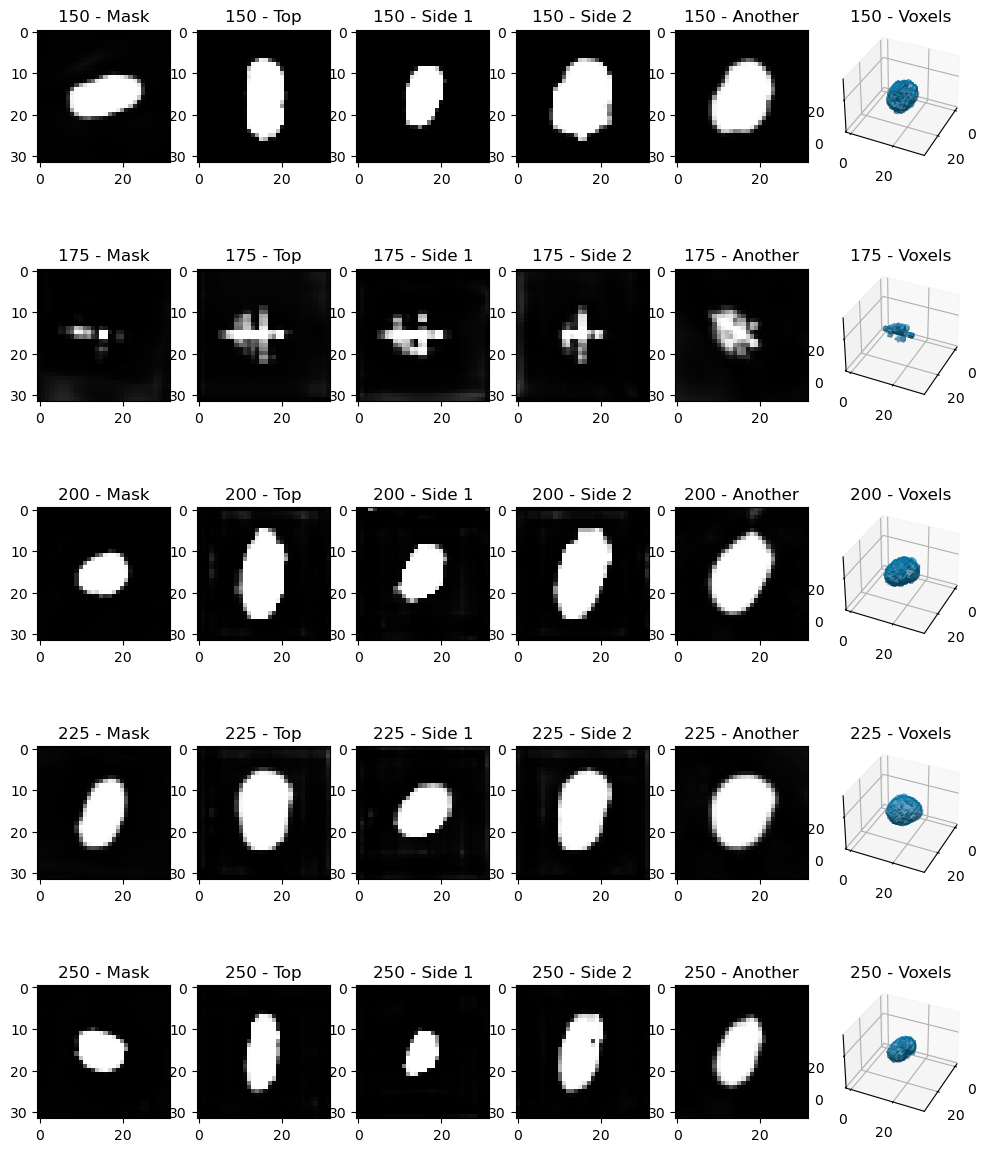

In [16]:
START_MODEL = 150
END_MODEL = 250

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen.eval()
mask_gen.eval()
mask_gen.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/bbbc039_gan_250.pt is loaded from epoch 250 , loss 0.6769


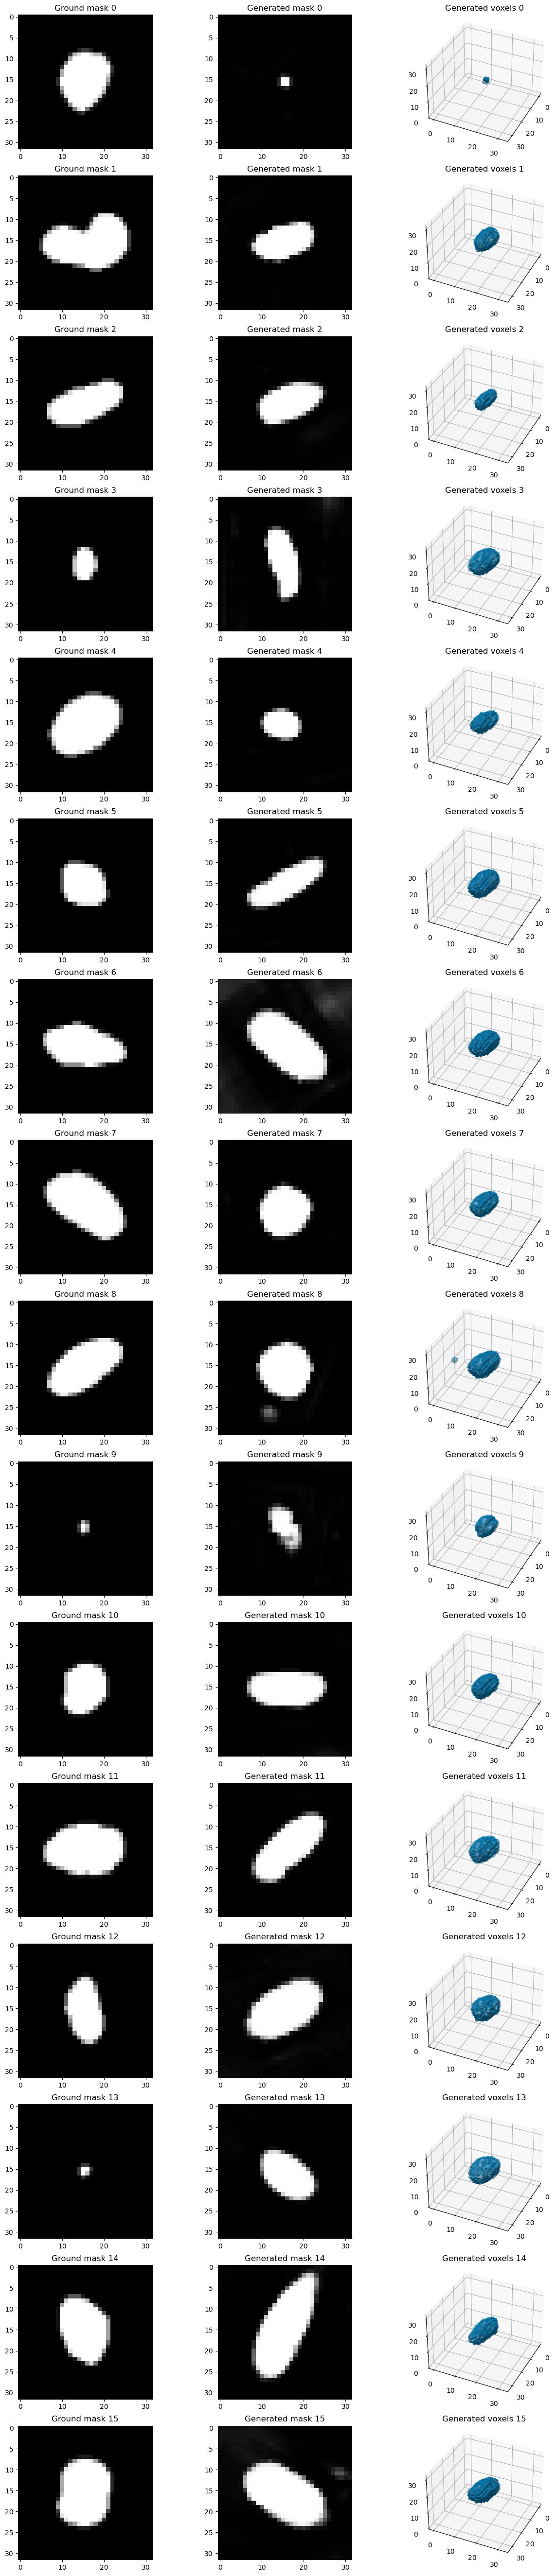

In [19]:
MODEL = 250
N_SAMPLES = 16

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(N_SAMPLES+1, LATENT_SIZE))).cuda()

plot_grid = []

for i in range(N_SAMPLES):
    masks = mask_gen(gen_input)[:N_SAMPLES]
    voxels = vox_gen(gen_input)[:N_SAMPLES]
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    rot_mask = cur_voxels.rotated(*np.random.uniform(0, np.pi*2, size=3)).create_image()
    rot_mask.title = f"Generated mask {i} (no noise)"
    cur_mask = metaimage.Mask(masks[i], title=f"Generated mask {i}")
    ground_mask = train_auto_dataset[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground mask {i}")

    plot_grid.append([ground_mask, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(15, N_SAMPLES*4.25))
display.show()

Model models/bbbc039_gan_4.pt is loaded from epoch 40 , loss 0.8812


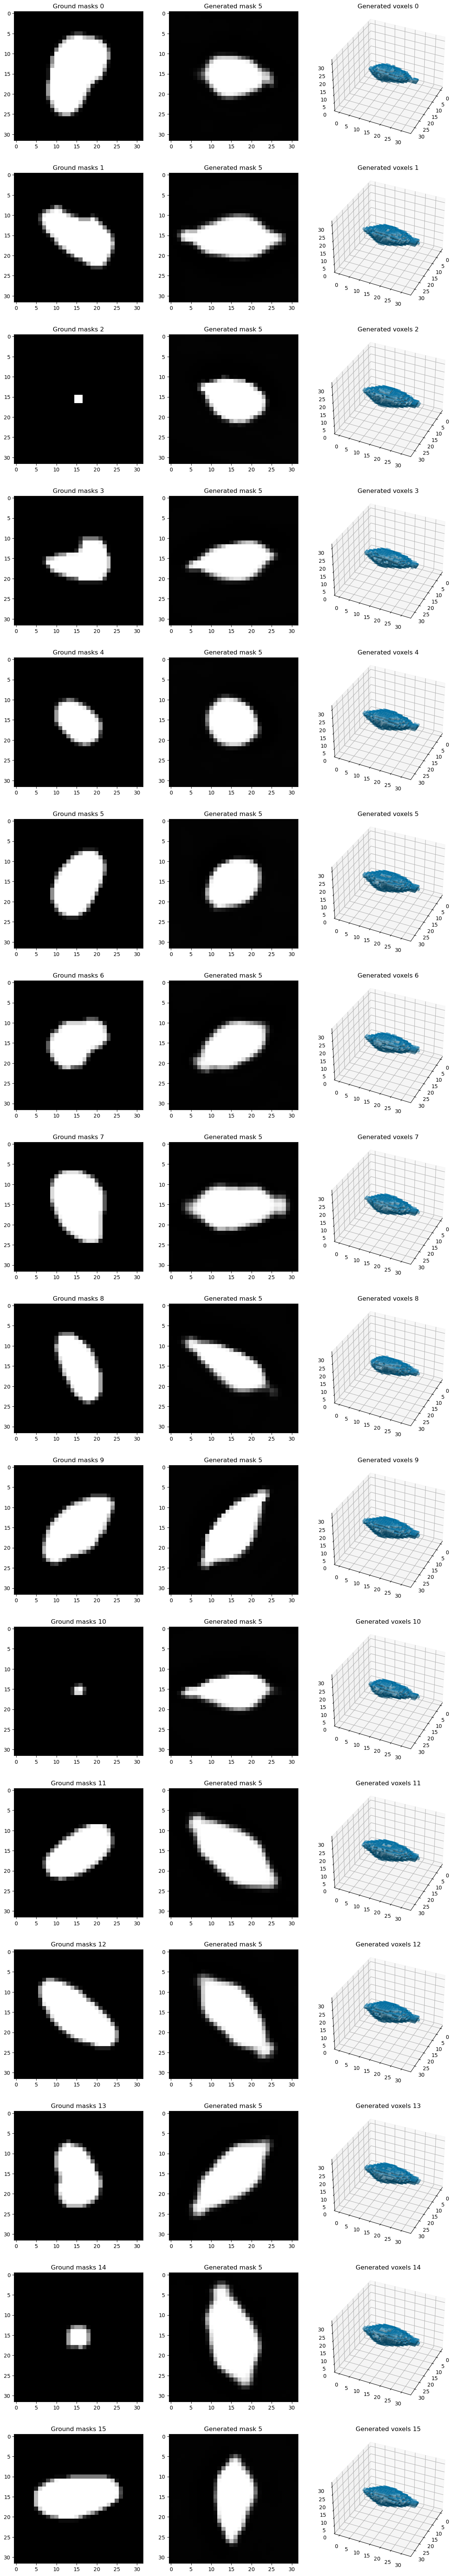

In [9]:
MODEL = 4

N_SAMPLES = 16

TRAIN_BASIS = 18

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(N_SAMPLES+1, LATENT_SIZE))).cuda()

mask_generator.train()
voxels = voxel_generator(gen_input)

voxel_grids = [voxgrid.VoxGrid(voxel, title=f"Generated voxels {i}") for i, voxel in enumerate(voxels)]

masks = [
    voxel_grid.rotated(*np.random.uniform(-np.pi, np.pi, 3)).create_image() for voxel_grid in voxel_grids
]
for mask in masks:
    mask.title = f"Generated mask {i}"

plot_grid = []

for i in range(N_SAMPLES):
    ground_mask = train_auto_dataset[i+TRAIN_BASIS][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground masks {i}")

    plot_grid.append([ground_mask, masks[i], voxel_grids[i]])

display.grid(plot_grid, figsize=(15, N_SAMPLES*5.5))
display.show()